In [7]:
import pandas as pd

target_path = "C:\\Users\\wongb\\Bridge-ML\\Bridge-ML-LLM-Embedding-Architecture\\data\\targets_10Sep.csv"
embeddings_path = "C:\\Users\\wongb\\Bridge-ML\\Bridge-ML-LLM-Embedding-Architecture\\nlp_data\\bridge_paragraphs_embedded.csv"
embeddings = pd.read_csv(embeddings_path)

In [8]:

# === Load Data ===
targets = pd.read_csv(target_path)
print(f"✅ Starting Number of Bridges: {len(targets):,}")
print(f"   Shape: {targets.shape}")

# === Track filtering impact ===
row_counts = {"Initial": len(targets)}

# 1️⃣ Support Type removals
support_type_removals = {
    "Not in BEISt": "Excluded due to missing in BEISt",
    "Not Bridge": "Not an actual bridge",
    "Single Span": "Single-span bridges excluded",
    "Wall": "Wall support type removed",
    "Tapered Wall": "Tapered wall support type removed",
    "CIP Piles": "CIP pile supports removed",
    "Timber piles": "Timber piles removed",
    "Timber Piles": "Timber piles removed (alt casing)",
    "Composite Piles": "Composite piles removed",
    "PC Piles": "PC piles removed",
    "Piles": "Generic piles removed",
    "H-Piles": "H-piles removed",
    "Tapered Col": "Tapered columns removed",
}

print("\n🔍 Support Type Removals:")
for val, reason in support_type_removals.items():
    count = (targets["Support Type"] == val).sum()
    if count > 0:
        print(f"  - {reason}: {count:,} rows")
        targets = targets[targets["Support Type"] != val].copy()

row_counts["After Support Type Filter"] = len(targets)
print(f"\n✅ After Support Type Filter: {len(targets):,} rows (removed {row_counts['Initial'] - len(targets):,})")

# 2️⃣ Structure ID filter
structure_id_exclude = ["Not in BEISt"]
count_before = len(targets)
for value in structure_id_exclude:
    count = (targets["Structure ID"] == value).sum()
    if count > 0:
        print(f"\n🔍 Structure ID Filter: Removing {count:,} rows where Structure ID == '{value}'")
        targets = targets[targets["Structure ID"] != value].copy()

row_counts["After Structure ID Filter"] = len(targets)
print(f"✅ After Structure ID Filter: {len(targets):,} rows (removed {count_before - len(targets):,})")

# 3️⃣ Feature Intersected filter
feature_intersected_exclude = ["Not Bridge"]
count_before = len(targets)
for value in feature_intersected_exclude:
    count = (targets["Feature Intersected"] == value).sum()
    if count > 0:
        print(f"\n🔍 Feature Intersected Filter: Removing {count:,} rows where Feature Intersected == '{value}'")
        targets = targets[targets["Feature Intersected"] != value].copy()

row_counts["After Feature Intersected Filter"] = len(targets)
print(f"✅ After Feature Intersected Filter: {len(targets):,} rows (removed {count_before - len(targets):,})")

# === Summary ===
print("\n" + "="*60)
print("📊 FILTERING SUMMARY:")
print("="*60)
for step, count in row_counts.items():
    print(f"{step:.<40} {count:>6,} rows")

print("\n" + "="*60)
print(f"🎯 Final Shape: {targets.shape}")
print(f"📉 Total Removed: {row_counts['Initial'] - len(targets):,} rows ({(row_counts['Initial'] - len(targets)) / row_counts['Initial'] * 100:.1f}%)")
print("="*60)

print("\n🔢 Remaining Support Types:")
print(targets["Support Type"].value_counts())



✅ Starting Number of Bridges: 850
   Shape: (850, 11)

🔍 Support Type Removals:
  - Excluded due to missing in BEISt: 8 rows
  - Not an actual bridge: 27 rows
  - Single-span bridges excluded: 115 rows
  - Wall support type removed: 40 rows
  - CIP pile supports removed: 4 rows
  - Timber piles removed: 29 rows
  - Composite piles removed: 1 rows
  - PC piles removed: 76 rows
  - H-piles removed: 2 rows
  - Tapered columns removed: 45 rows

✅ After Support Type Filter: 503 rows (removed 347)

🔍 Structure ID Filter: Removing 16 rows where Structure ID == 'Not in BEISt'
✅ After Structure ID Filter: 487 rows (removed 16)
✅ After Feature Intersected Filter: 487 rows (removed 0)

📊 FILTERING SUMMARY:
Initial.................................    850 rows
After Support Type Filter...............    503 rows
After Structure ID Filter...............    487 rows
After Feature Intersected Filter........    487 rows

🎯 Final Shape: (487, 11)
📉 Total Removed: 363 rows (42.7%)

🔢 Remaining Support Ty

In [9]:
# --- Rename columns for consistency ---
rename_map = {
    'Structure ID': 'STRUCTURE_ID',
    'Spacing/Pitch (in)': 'SPACING_PITCH_IN',
    'No. of Columns/Piles per Bent': 'COLUMNS_PILES_PER_BENT',
    'B_long (in.)': 'B_LONG_IN',
    'B_trans (in.)': 'B_TRANS_IN',
    'Clear Height (ft)': 'CLEAR_HEIGHT_FT',
    'Support Type': 'SUPPORT_TYPE',
    'Feature Intersected': 'OBJECT_INTERSECTED',
    'Long Reinf Ratio, %': 'LRR',
    'Transverse Reinforcement Ratio': 'TRR',
    'Database Ref #': 'DATABASE_REF'
}

missing_cols = [col for col in rename_map if col not in targets.columns]
valid_renames = {k: v for k, v in rename_map.items() if k in targets.columns}
targets = targets.rename(columns=valid_renames)

print(f"✅ Renamed {len(valid_renames)} columns for consistency.")
if missing_cols:
    print(f"⚠️ Skipped missing columns: {missing_cols}")

✅ Renamed 11 columns for consistency.


In [10]:
import numpy as np
import pandas as pd

# --- Engineered / Calculated Features ---

print("\n🧩 Adding engineered features...")

# === 1️⃣ Columns/Piles 0/1 ===
# Ensure numeric type first — coerce non-numerics to NaN
targets["COLUMNS_PILES_PER_BENT"] = pd.to_numeric(
    targets["COLUMNS_PILES_PER_BENT"], errors="coerce"
)

# Convert dimension columns to numeric
targets["B_LONG_IN"] = pd.to_numeric(targets["B_LONG_IN"], errors="coerce")
targets["B_TRANS_IN"] = pd.to_numeric(targets["B_TRANS_IN"], errors="coerce")
targets["CLEAR_HEIGHT_FT"] = pd.to_numeric(targets["CLEAR_HEIGHT_FT"], errors="coerce")
targets["LRR"] = pd.to_numeric(targets["LRR"], errors="coerce")
targets["TRR"] = pd.to_numeric(targets["TRR"], errors="coerce")

# 0 if exactly one pile/column per bent, 1 if more than one, NaN if missing.
targets["COLUMNS_PILES_0_1"] = np.select(
    [
        targets["COLUMNS_PILES_PER_BENT"].notna() & (targets["COLUMNS_PILES_PER_BENT"] == 1),
        targets["COLUMNS_PILES_PER_BENT"].notna() & (targets["COLUMNS_PILES_PER_BENT"] > 1),
    ],
    [0, 1],
    default=np.nan,
)
# Convert to nullable integer using pd.array for compatibility
targets["COLUMNS_PILES_0_1"] = pd.array(targets["COLUMNS_PILES_0_1"], dtype=pd.Int64Dtype())

# === 2️⃣ L/H Ratios ===
# Multiply by 12 to convert ft to in before ratio.
targets["L_H_LONG"] = (targets["CLEAR_HEIGHT_FT"] * 12) / targets["B_LONG_IN"]
targets["L_H_TRANS"] = (targets["CLEAR_HEIGHT_FT"] * 12) / targets["B_TRANS_IN"]

# Minimum slenderness ratio
targets["L_H_MIN"] = targets[["L_H_LONG", "L_H_TRANS"]].min(axis=1)

# === 3️⃣ Material / Design Constants ===
f_prime_c = 6000  # psi
f_y = 60000       # psi
f_y_t = 60000     # psi
eta = 0.5
pi_4 = np.pi / 4
C_0 = 1.6
C_1 = 1.3

sqrt_fc_fy = np.sqrt(f_prime_c) / f_y
fyt_fy = f_y_t / f_y

# === 4️⃣ Z_KNOWN (from pile/column presence) ===
targets["Z_KNOWN"] = targets["COLUMNS_PILES_0_1"].map({0: 1, 1: 2})

# === 5️⃣ Capacity / Demand Ratios ===
# The following calculations originate from the "Helper Tables" shear formulas in the old database.
# Some were commented out historically — kept as optional formulas for reference.

# Optional / inactive metrics (preserved for clarity)
# targets["CD_LONG"] = (
#     (C_0 * sqrt_fc_fy + 0.4 * targets["TRR"] * fyt_fy * targets["L_H_LONG"])
#     / (C_1 * 1 * pi_4 * eta * targets["LRR"])
# )
#
# targets["CD_TRANS"] = (
#     (C_0 * sqrt_fc_fy + 0.4 * targets["TRR"] * fyt_fy * targets["L_H_TRANS"])
#     / (C_1 * targets["Z_KNOWN"] * pi_4 * eta * targets["LRR"])
# )
#
# targets["CD_MIN"] = targets[["CD_LONG", "CD_TRANS"]].min(axis=1)

# Active formula used in previous version:
targets["CD_MIN"] = (
    (C_0 * sqrt_fc_fy + 0.5 * targets["TRR"] * fyt_fy) * targets["L_H_MIN"]
) / (C_1 * targets["Z_KNOWN"] * pi_4 * eta * targets["LRR"])

# Handle divide-by-zero or missing LRR safely
targets.loc[targets["LRR"] == 0, "CD_MIN"] = np.nan

# === SCCI  ===
# This is the same as CD_MIN - the capacity/demand ratio
targets["SCCI"] = targets["CD_MIN"]

# === 6️⃣ Critical Truth 0/1 ===
# 1 if CD_MIN < 0.85, 0 otherwise, NaN if missing.
targets["CRITICAL_TRUTH_0_1"] = np.where(
    targets["CD_MIN"].notna(),
    np.where(targets["CD_MIN"] < 0.85, 1, 0),
    np.nan,
)
# Convert to nullable integer using pd.array for compatibility
targets["CRITICAL_TRUTH_0_1"] = pd.array(targets["CRITICAL_TRUTH_0_1"], dtype=pd.Int64Dtype())

print("✅ Engineered features added successfully.")



🧩 Adding engineered features...
✅ Engineered features added successfully.


In [11]:
targets.to_csv(r"C:\Users\wongb\Bridge-ML\Bridge-ML-LLM-Embedding-Architecture\ml\targets.csv", index=True)

In [7]:
# Merge DataFrames on 'Structure ID'
merged_1 = pd.merge(targets, embeddings, on='STRUCTURE_ID', how='inner')

# Filter out rows where SCCI is missing
print(f"Before SCCI filter: {len(merged_1):,} rows")
merged_1 = merged_1[merged_1['SCCI'].notna()].copy()
print(f"After SCCI filter: {len(merged_1):,} rows (removed {len(pd.merge(targets, embeddings, on='STRUCTURE_ID', how='inner')) - len(merged_1):,} rows with missing SCCI)")

# Make Database_Ref the index
merged_1 = merged_1.set_index('DATABASE_REF').copy()

Before SCCI filter: 478 rows
After SCCI filter: 370 rows (removed 108 rows with missing SCCI)


In [8]:
merged_1.to_csv("merged_1.csv", index=True)
print(f"💾 Saved merged_1 to: merged_1.csv")
merged_1 

💾 Saved merged_1 to: merged_1.csv


,STRUCTURE_ID,OBJECT_INTERSECTED,SUPPORT_TYPE,COLUMNS_PILES_PER_BENT,B_LONG_IN,B_TRANS_IN,CLEAR_HEIGHT_FT,LRR,SPACING_PITCH_IN,TRR,...,L_H_LONG,L_H_TRANS,L_H_MIN,Z_KNOWN,CD_MIN,SCCI,CRITICAL_TRUTH_0_1,COORDINATES,PARAGRAPH,EMBEDDING
DATABASE_REF,,,,,,,,,,,,,,,,,,,,,
1,0019133A,Overpass,RectCol-Spiral,4.0,54.0,54.0,19.20,0.0155,6,0.0077,...,4.266667,4.266667,4.266667,2.0,1.594858,1.594858,0,"(47.11858333, -122.5570833)",Design Peak Ground Acceleration: High seismic ...,"[-0.047811899334192276, 0.021526260301470757, ..."
2,0019133D,Overpass,RectCol-Spiral,2.0,48.0,48.0,24.60,0.0140,4,0.0096,...,6.150000,6.150000,6.150000,2.0,2.953873,2.953873,0,"(47.12700556, -122.5440667)",Design Peak Ground Acceleration: High seismic ...,"[-0.04653189703822136, 0.010406211949884892, -..."
7,0005582A,Overpass,CircCol,4.0,36.0,36.0,34.40,0.0123,12,0.0020,...,11.466667,11.466667,11.466667,2.0,2.799066,2.799066,0,"(47.14755833, -122.5044194)",Design Peak Ground Acceleration: High seismic ...,"[-0.03944757208228111, 0.013299819082021713, -..."
8,0005523C,Overpass,CircCol,1.0,60.0,60.0,18.00,0.0099,12,0.0011,...,3.600000,3.600000,3.600000,1.0,1.863090,1.863090,0,"(47.15058056, -122.4991778)",Design Peak Ground Acceleration: High seismic ...,"[-0.04027041792869568, 0.010956468991935253, -..."
9,0005651A,Overpass,CircCol,1.0,72.0,72.0,25.20,0.0092,12,0.0010,...,4.200000,4.200000,4.200000,1.0,2.294276,2.294276,0,"(47.15976389, -122.4835889)",Design Peak Ground Acceleration: High seismic ...,"[-0.04816442355513573, 0.019141199067234993, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,0014354B,Water,RectCol,2.0,42.0,57.0,46.60,0.0149,3.5,0.0217,...,13.314286,9.810526,9.810526,2.0,8.328889,8.328889,0,"(47.30272222, -122.1776111)",Design Peak Ground Acceleration: High seismic ...,"[-0.049299225211143494, 0.011558284051716328, ..."
841,0016611B,Water,CircCol,2.0,60.0,60.0,47.30,0.0184,3.5,0.0087,...,9.460000,9.460000,9.460000,2.0,3.230552,3.230552,0,"(47.40619444, -122.0420556)",Design Peak Ground Acceleration: High seismic ...,"[-0.043081093579530716, 0.012732699513435364, ..."
842,0016611A,Underpass,CircCol,2.0,60.0,60.0,38.70,0.0127,3.5,0.0087,...,7.740000,7.740000,7.740000,2.0,3.829488,3.829488,0,"(47.40606667, -122.0417028)",Design Peak Ground Acceleration: High seismic ...,"[-0.04832514747977257, 0.009402559138834476, -..."


🔍 Computing pairwise cosine similarity...

📊 Cosine Similarity Statistics:
  Mean similarity: 0.9789
  Median similarity: 0.9794
  Std deviation: 0.0054
  Min similarity: 0.9539
  Max similarity: 0.9977

🔎 Pairs with similarity > 0.95: 68265

Top 10 most similar pairs:
  1. Structures 493 ↔ 495: 0.9977
  2. Structures 59 ↔ 60: 0.9968
  3. Structures 468 ↔ 469: 0.9967
  4. Structures 361 ↔ 362: 0.9954
  5. Structures 488 ↔ 489: 0.9953
  6. Structures 829 ↔ 842: 0.9950
  7. Structures 455 ↔ 467: 0.9950
  8. Structures 442 ↔ 448: 0.9950
  9. Structures 494 ↔ 495: 0.9943
  10. Structures 303 ↔ 304: 0.9943


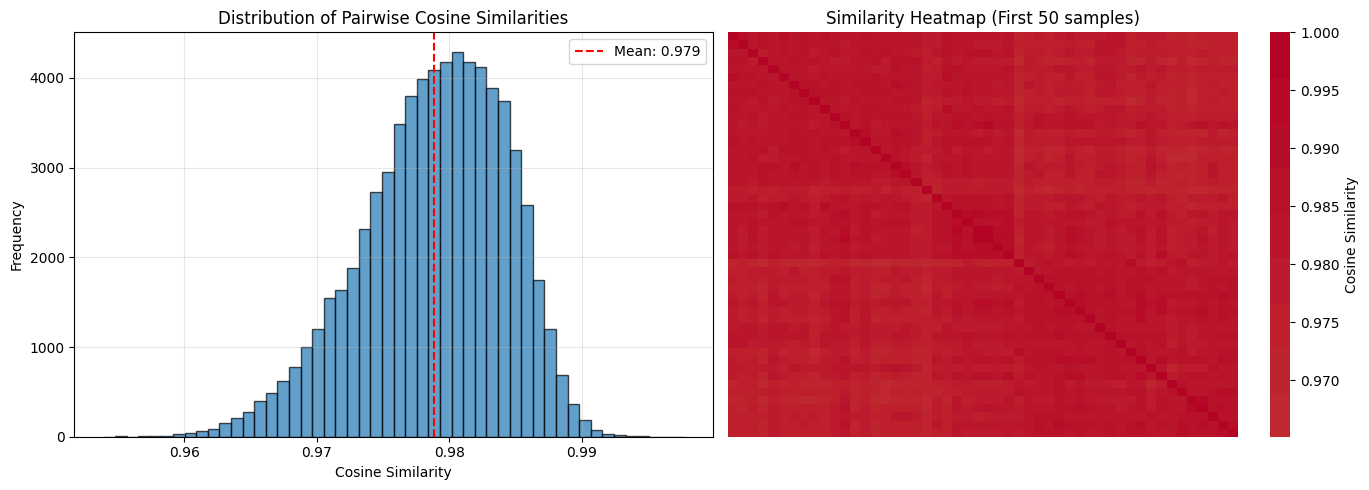


✅ Cosine similarity analysis complete!


In [13]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# === Cosine Similarity Analysis ===
print("🔍 Computing pairwise cosine similarity...")

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(X)

# Get upper triangle (exclude diagonal and duplicates)
upper_tri_indices = np.triu_indices_from(similarity_matrix, k=1)
similarity_values = similarity_matrix[upper_tri_indices]

# Statistics
print(f"\n📊 Cosine Similarity Statistics:")
print(f"  Mean similarity: {similarity_values.mean():.4f}")
print(f"  Median similarity: {np.median(similarity_values):.4f}")
print(f"  Std deviation: {similarity_values.std():.4f}")
print(f"  Min similarity: {similarity_values.min():.4f}")
print(f"  Max similarity: {similarity_values.max():.4f}")

# High similarity pairs (potential duplicates or very similar bridges)
high_similarity_threshold = 0.95
high_sim_mask = similarity_values > high_similarity_threshold
high_sim_count = high_sim_mask.sum()

print(f"\n🔎 Pairs with similarity > {high_similarity_threshold}: {high_sim_count}")

if high_sim_count > 0:
    print("\nTop 10 most similar pairs:")
    row_idx, col_idx = upper_tri_indices
    sorted_indices = np.argsort(similarity_values)[::-1][:10]
    
    for rank, idx in enumerate(sorted_indices, 1):
        i, j = row_idx[idx], col_idx[idx]
        sim = similarity_values[idx]
        # Get structure IDs if available
        struct_ids = merged_1.index.tolist()
        print(f"  {rank}. Structures {struct_ids[i]} ↔ {struct_ids[j]}: {sim:.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of similarities
axes[0].hist(similarity_values, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(similarity_values.mean(), color='red', linestyle='--', label=f'Mean: {similarity_values.mean():.3f}')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Pairwise Cosine Similarities')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Heatmap sample (first 50x50 for visibility)
sample_size = min(50, len(similarity_matrix))
sns.heatmap(similarity_matrix[:sample_size, :sample_size], 
            cmap='coolwarm', center=0.5, 
            xticklabels=False, yticklabels=False,
            cbar_kws={'label': 'Cosine Similarity'},
            ax=axes[1])
axes[1].set_title(f'Similarity Heatmap (First {sample_size} samples)')

plt.tight_layout()
plt.show()

print(f"\n✅ Cosine similarity analysis complete!")

In [21]:
import json
import os
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# === Paths ===
enriched_data_path = Path("C:/Users/wongb/Bridge-ML/Bridge-ML-LLM-Embedding-Architecture/enriched_data_fixed")
schemas_path = Path("C:/Users/wongb/Bridge-ML/Bridge-ML-LLM-Embedding-Architecture/final_schemas")

print("🔧 Building numerical feature vectors from enriched data...")

# === Step 1: Collect all numerical features ===
all_numerical_features = {}  # Key: (STRUCTURE_ID, COORDINATES), Value: list of features

# Get all CSV files
csv_files = list(enriched_data_path.glob("*.csv"))
print(f"Found {len(csv_files)} CSV files")

for csv_file in csv_files:
    csv_name = csv_file.stem  # e.g., 'design_maps'
    
    # Find matching schema
    schema_file = schemas_path / f"{csv_name}_schema_master.json"
    
    if not schema_file.exists():
        print(f"⚠️ No schema found for {csv_name}, skipping...")
        continue
    
    # Load schema
    with open(schema_file, 'r') as f:
        schema = json.load(f)
    
    # Load CSV
    df = pd.read_csv(csv_file)
    
    # Check if STRUCTURE_ID and COORDINATES exist
    if 'STRUCTURE_ID' not in df.columns:
        print(f"⚠️ No STRUCTURE_ID in {csv_name}, skipping...")
        continue
    if 'COORDINATES' not in df.columns:
        print(f"⚠️ No COORDINATES in {csv_name}, skipping...")
        continue
    
    print(f"\n📊 Processing {csv_name}...")
    print(f"   Rows: {len(df):,}")
    
    # Find numerical columns from schema (exclude STRUCTURE_ID and COORDINATES)
    numerical_cols = []
    numerical_col_info = {}  # Store type and code_map for each column
    
    for field_name, field_info in schema.items():
        field_type = field_info.get('type', '')
        
        # Check if it's numerical or numerical_coded
        if field_type in ['numerical', 'numerical_coded']:
            # Check if column exists in dataframe and is not an identifier
            if field_name in df.columns and field_name not in ['STRUCTURE_ID', 'COORDINATES']:
                numerical_cols.append(field_name)
                numerical_col_info[field_name] = {
                    'type': field_type,
                    'code_map': field_info.get('code_map', {})
                }
    
    print(f"   Found {len(numerical_cols)} numerical columns")
    
    if len(numerical_cols) == 0:
        continue
    
    # Extract numerical features for each structure
    for _, row in df.iterrows():
        struct_id = row['STRUCTURE_ID']
        coordinates = row['COORDINATES']
        
        # Use tuple as key for unique identification
        bridge_key = (struct_id, coordinates)
        
        if bridge_key not in all_numerical_features:
            all_numerical_features[bridge_key] = []
        
        # Collect values, converting to float and handling missing values
        for col in numerical_cols:
            val = row[col]
            col_info = numerical_col_info[col]
            
            # Check if this is a coded value that should be treated as missing
            if col_info['type'] == 'numerical_coded' and col_info['code_map']:
                # Check if value matches any key in code_map (treat as missing)
                if val in col_info['code_map'] or str(val) in col_info['code_map']:
                    val_float = np.nan
                else:
                    try:
                        val_float = float(val)
                        # Replace inf and -inf with NaN
                        if np.isinf(val_float):
                            val_float = np.nan
                    except (ValueError, TypeError):
                        val_float = np.nan
            else:
                try:
                    val_float = float(val)
                    # Replace inf and -inf with NaN
                    if np.isinf(val_float):
                        val_float = np.nan
                except (ValueError, TypeError):
                    val_float = np.nan
            
            all_numerical_features[bridge_key].append(val_float)

print(f"\n✅ Collected features for {len(all_numerical_features):,} unique bridges (STRUCTURE_ID + COORDINATES)")

# === Step 2: Check feature consistency and pad if needed ===
print("\n🔧 Checking feature vector lengths...")

feature_lengths = [len(feats) for feats in all_numerical_features.values()]
max_length = max(feature_lengths)
min_length = min(feature_lengths)

print(f"Feature vector lengths: min={min_length}, max={max_length}")

if min_length != max_length:
    print(f"⚠️ Inconsistent feature lengths detected. Padding to {max_length} features...")
    # Pad shorter vectors with NaN
    for bridge_key in all_numerical_features:
        current_length = len(all_numerical_features[bridge_key])
        if current_length < max_length:
            padding = [np.nan] * (max_length - current_length)
            all_numerical_features[bridge_key].extend(padding)

# === Step 3: Create feature matrix ===
print("\n🔧 Creating numerical feature matrix...")

bridge_keys = list(all_numerical_features.keys())
structure_ids = [key[0] for key in bridge_keys]
coordinates = [key[1] for key in bridge_keys]
feature_matrix = []

for bridge_key in bridge_keys:
    feature_matrix.append(all_numerical_features[bridge_key])

feature_matrix = np.array(feature_matrix, dtype=float)
print(f"Feature matrix shape: {feature_matrix.shape}")

# === Step 4: Handle missing values (impute with column mean) ===
print("\n🔧 Handling missing values...")
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
feature_matrix_imputed = imputer.fit_transform(feature_matrix)

# Count missing values before and after
n_missing_before = np.isnan(feature_matrix).sum()
n_missing_after = np.isnan(feature_matrix_imputed).sum()
print(f"Missing values before imputation: {n_missing_before:,}")
print(f"Missing values after imputation: {n_missing_after:,}")

# === Step 5: Normalize features ===
print("\n🔧 Normalizing features...")
scaler_numerical = StandardScaler()
feature_matrix_normalized = scaler_numerical.fit_transform(feature_matrix_imputed)

print(f"Normalized matrix shape: {feature_matrix_normalized.shape}")
print(f"Mean: {feature_matrix_normalized.mean():.6f}")
print(f"Std: {feature_matrix_normalized.std():.6f}")

# === Step 6: Create dataframe ===
numerical_df = pd.DataFrame({
    'STRUCTURE_ID': structure_ids,
    'COORDINATES': coordinates,
    'NUMERICAL_VECTOR': [list(row) for row in feature_matrix_normalized]
})

print(f"\n✅ Created numerical_df with {len(numerical_df):,} unique bridges")
print(f"   Vector dimension: {feature_matrix_normalized.shape[1]}")
numerical_df.head()

🔧 Building numerical feature vectors from enriched data...
Found 7 CSV files

📊 Processing design_maps...
   Rows: 4,914
   Found 7 numerical columns

📊 Processing macrostrat...
   Rows: 4,914
   Found 2 numerical columns

📊 Processing nbi_nominal...
   Rows: 4,914
   Found 0 numerical columns

📊 Processing nbi_numerical...
   Rows: 4,914
   Found 23 numerical columns

📊 Processing nbi_numerical_coded...
   Rows: 4,914
   Found 8 numerical columns

📊 Processing nfhl_fema_flood...
   Rows: 4,914
   Found 1 numerical columns

📊 Processing nshm_hazard_grid...
   Rows: 4,914
   Found 12 numerical columns

✅ Collected features for 4,914 unique bridges (STRUCTURE_ID + COORDINATES)

🔧 Checking feature vector lengths...
Feature vector lengths: min=53, max=53

🔧 Creating numerical feature matrix...
Feature matrix shape: (4914, 53)

🔧 Handling missing values...
Missing values before imputation: 24,178
Missing values after imputation: 0

🔧 Normalizing features...
Normalized matrix shape: (4914, 5

C:\Users\wongb\AppData\Roaming\Python\Python313\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: [26]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


,STRUCTURE_ID,COORDINATES,NUMERICAL_VECTOR
0,1W,"(48.29745556, -122.6078139)","[0.6036697527894314, 0.6182504859889012, 0.248..."
1,,"(47.769275, -122.707925)","[-0.18026194170011112, 0.6548053013325548, 0.2..."
2,,"(47.56759167, -122.5517028)","[1.4766845943800584, 1.6336620233125998, 0.913..."
3,00000000,"(47.25279444, -124.178075)","[2.2071664006089513, 1.4671345311915134, 2.599..."
4,,"(47.98571667, -122.2271222)","[0.16716233199411837, 0.2161475172087166, -0.1..."


In [22]:
# === Merge with merged_1 to create merged_2 ===
print("🔗 Merging numerical vectors with merged_1...")

# Reset index to make DATABASE_REF a column again
merged_1_reset = merged_1.reset_index()

# Merge on both STRUCTURE_ID and COORDINATES
merged_2 = pd.merge(merged_1_reset, numerical_df, on=['STRUCTURE_ID', 'COORDINATES'], how='inner')

print(f"Before merge: {len(merged_1_reset):,} rows")
print(f"After merge: {len(merged_2):,} rows")
print(f"Rows lost: {len(merged_1_reset) - len(merged_2):,}")

# Set DATABASE_REF back as index
merged_2 = merged_2.set_index('DATABASE_REF')

# Save
merged_2.to_csv("merged_2.csv", index=True)
print(f"\n💾 Saved merged_2 to: merged_2.csv")

print(f"\n✅ merged_2 shape: {merged_2.shape}")
print(f"   Columns: {list(merged_2.columns)}")
merged_2.head()

🔗 Merging numerical vectors with merged_1...
Before merge: 370 rows
After merge: 370 rows
Rows lost: 0

💾 Saved merged_2 to: merged_2.csv

✅ merged_2 shape: (370, 22)
   Columns: ['STRUCTURE_ID', 'OBJECT_INTERSECTED', 'SUPPORT_TYPE', 'COLUMNS_PILES_PER_BENT', 'B_LONG_IN', 'B_TRANS_IN', 'CLEAR_HEIGHT_FT', 'LRR', 'SPACING_PITCH_IN', 'TRR', 'COLUMNS_PILES_0_1', 'L_H_LONG', 'L_H_TRANS', 'L_H_MIN', 'Z_KNOWN', 'CD_MIN', 'SCCI', 'CRITICAL_TRUTH_0_1', 'COORDINATES', 'PARAGRAPH', 'EMBEDDING', 'NUMERICAL_VECTOR']


,STRUCTURE_ID,OBJECT_INTERSECTED,SUPPORT_TYPE,COLUMNS_PILES_PER_BENT,B_LONG_IN,B_TRANS_IN,CLEAR_HEIGHT_FT,LRR,SPACING_PITCH_IN,TRR,...,L_H_TRANS,L_H_MIN,Z_KNOWN,CD_MIN,SCCI,CRITICAL_TRUTH_0_1,COORDINATES,PARAGRAPH,EMBEDDING,NUMERICAL_VECTOR
DATABASE_REF,,,,,,,,,,,,,,,,,,,,,
1,0019133A,Overpass,RectCol-Spiral,4.0,54.0,54.0,19.2,0.0155,6,0.0077,...,4.266667,4.266667,2.0,1.594858,1.594858,0,"(47.11858333, -122.5570833)",Design Peak Ground Acceleration: High seismic ...,"[-0.047811899334192276, 0.021526260301470757, ...","[-0.20698688583043648, 0.5695107321973636, 0.1..."
2,0019133D,Overpass,RectCol-Spiral,2.0,48.0,48.0,24.6,0.0140,4,0.0096,...,6.150000,6.150000,2.0,2.953873,2.953873,0,"(47.12700556, -122.5440667)",Design Peak Ground Acceleration: High seismic ...,"[-0.04653189703822136, 0.010406211949884892, -...","[-0.20698688583043648, 0.5613874398987739, 0.1..."
7,0005582A,Overpass,CircCol,4.0,36.0,36.0,34.4,0.0123,12,0.0020,...,11.466667,11.466667,2.0,2.799066,2.799066,0,"(47.14755833, -122.5044194)",Design Peak Ground Acceleration: High seismic ...,"[-0.03944757208228111, 0.013299819082021713, -...","[-0.20698688583043648, 0.5370175630030052, 0.0..."
8,0005523C,Overpass,CircCol,1.0,60.0,60.0,18.0,0.0099,12,0.0011,...,3.600000,3.600000,1.0,1.863090,1.863090,0,"(47.15058056, -122.4991778)",Design Peak Ground Acceleration: High seismic ...,"[-0.04027041792869568, 0.010956468991935253, -...","[-0.20698688583043648, 0.5329559168537108, 0.0..."
9,0005651A,Overpass,CircCol,1.0,72.0,72.0,25.2,0.0092,12,0.0010,...,4.200000,4.200000,1.0,2.294276,2.294276,0,"(47.15976389, -122.4835889)",Design Peak Ground Acceleration: High seismic ...,"[-0.04816442355513573, 0.019141199067234993, 0...","[-0.20698688583043648, 0.5248326245551213, 0.0..."


In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import numpy as np
import ast

# === Configuration: Choose feature types ===
FEATURE_MODE = 'combined'  # Options: 'combined', 'embeddings_only', 'numerical_only'

# === 1️⃣ Prepare data based on selected mode ===
print(f"🔧 Preparing features using mode: {FEATURE_MODE}")

# Extract embedding vectors
if isinstance(merged_2['EMBEDDING'].iloc[0], str):
    embeddings = np.array([ast.literal_eval(emb) if isinstance(emb, str) else emb 
                           for emb in merged_2['EMBEDDING']])
else:
    embeddings = np.array(merged_2['EMBEDDING'].tolist())

# Extract numerical vectors
if isinstance(merged_2['NUMERICAL_VECTOR'].iloc[0], str):
    numerical = np.array([ast.literal_eval(vec) if isinstance(vec, str) else vec 
                          for vec in merged_2['NUMERICAL_VECTOR']])
else:
    numerical = np.array(merged_2['NUMERICAL_VECTOR'].tolist())

# Select features based on mode
if FEATURE_MODE == 'combined':
    X_features = np.hstack([embeddings, numerical])
    print(f"Embeddings shape: {embeddings.shape}")
    print(f"Numerical features shape: {numerical.shape}")
    print(f"Combined data shape: {X_features.shape[0]} samples × {X_features.shape[1]} features")
elif FEATURE_MODE == 'embeddings_only':
    X_features = embeddings
    print(f"Using embeddings only: {X_features.shape[0]} samples × {X_features.shape[1]} features")
elif FEATURE_MODE == 'numerical_only':
    X_features = numerical
    print(f"Using numerical features only: {X_features.shape[0]} samples × {X_features.shape[1]} features")
else:
    raise ValueError(f"Invalid FEATURE_MODE: {FEATURE_MODE}. Choose 'combined', 'embeddings_only', or 'numerical_only'")

y = merged_2['SCCI'].values

# === 2️⃣ PCA + Scaling ===
scaler = StandardScaler()
pca = PCA(n_components=0.95)  # Keep 95% variance or set fixed like 50-100 components

X_scaled = scaler.fit_transform(X_features)
X_pca = pca.fit_transform(X_scaled)
print(f"Reduced from {X_features.shape[1]} to {X_pca.shape[1]} components (95% variance retained)")

# === 3️⃣ Quick baseline with CV ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'RandomForest': RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42, verbosity=0)
}

print("\n" + "="*60)
print(f"📈 MODEL PERFORMANCE ({FEATURE_MODE.upper()}) - 5-Fold CV")
print("="*60)

for name, model in models.items():
    scores = cross_val_score(model, X_pca, y, cv=kf, scoring='r2')
    print(f"{name:20} R² = {scores.mean():.4f} ± {scores.std():.4f}")
    
print("="*60)

🔧 Preparing features using mode: combined
Embeddings shape: (370, 1024)
Numerical features shape: (370, 52)
Combined data shape: 370 samples × 1076 features
Reduced from 1076 to 177 components (95% variance retained)

📈 MODEL PERFORMANCE (COMBINED) - 5-Fold CV
Ridge                R² = -1.2684 ± 0.3948
Lasso                R² = -0.0671 ± 0.0639
RandomForest         R² = -0.0775 ± 0.1514
GradientBoosting     R² = -0.1027 ± 0.1315
XGBoost              R² = -0.0832 ± 0.1310
